# Section 1: Introduction

#### Goals and Objectives: 
Implement a couple of machine learning techniques that accurately predicts fraudulent credit card transactions. In addition to the machine learning applications, explore the data via EDA to gain a better understanding of features, although this maybe limited considering all numeric features were reduced to principal components of the original variables. 


#### Data description: https://www.kaggle.com/dalpozz/creditcardfraud
This is a current Kaggle data set where the task is to predict fraud. It contains credit card transactions made in 2013 by European card holders, recorded over a two-day period. It has about 285 thousand observations and 31 features. In total, there are only 492 fraudulent transactions (0.17%) and 285 thousand non-fraud transactions. For privacy reasons, all numeric features were reduced to lower dimension before distribution, using PCA into 28 principal components V1 through V28. For similar reasons, no additional feature descriptions were provided. Other variables were Time (time elapsed after the first transaction) and Amount (charged transaction) as well as the class label where 1 represented fraud event and 0 otherwise. A major limitation in the data was the severe class-imbalance which represented a significant challenge in correctly classifying fraud.

#### Approach
After preprocessng the data, the techniques attempted are a logistic regression and a random forest. Thereafter, we balanced the data using techniques presented in section 3 - data balancing. With class imbalance, correct measures of accuracy are recall, precsion, and F1-score. We noted that both two algorithms did not peform well with the imbalanced data, though the random forest was materially better compared to the logistic regression. After employing resampling techniques - undersampling - we hyperparameter tuned a new random forest on the balanced undersampled data, then using the best estimators, fit a FINAL random forest where we achieved robust recall values.

* Logistic Regression: the choice of the logistic regression was more about explainability rather than accuracy. However as will see below, this data set may have been too complex for a simple logistic regression thus the lower performance of the model. 

* Random forest:  as noted under section 3 - balancing data - one of the techniques to handling class imbalance is to employ ensemble techniques. Partly, this was the reason for the choice of the random forest. However, when trained on the class imbalanced data and validated on the unseen class imbalanced test, the random forest, while providing modest improvement over the logistic regression, it did not provide optimal results. Therefore, for the final model, we again chose to hyperparameter tune a random forest, trained on class balanced data, and validated on class imbalanced unseen test set. As shown below, this final model peformed exceedingly well.

In [1]:
# load initial libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
pwd

'C:\\cygwin64\\home\\Collins Nyagaya'

In [3]:
cd C:\Users\Collins Nyagaya\Documents\Python Scripts

C:\Users\Collins Nyagaya\Documents\Python Scripts


In [4]:
# read in the data and visualize header
# v1 - v28 appear to beon same scale, from feature "amount", scaling maybe needed
credit = pd.read_csv("creditcard.csv", na_values=["?"])
credit.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# Section 2: Data Preprocessing

Feature "time" is the number of seconds elapsed between each transaction and the first transaction in the dataset. Feature 'Amount' is the transaction Amount, while feature 'Class' is the target variable and with value 1 = fraud and 0 otherwise. As noted earlier, the other variables v1-v28 are principal components of the original data.

In [5]:
# examining the shape - 31 variables in total, with close to 285K credit card transactions
credit.shape

(284807, 31)

In [6]:
# We see the data has two classes - per data description, 1=fraud, 0 otherwise
pd.unique(credit["Class"].values.ravel())
# number of classes
print("Number of classes:", len(pd.unique(credit["Class"].values.ravel())))

Number of classes: 2


As expected, the dataset suffers from severe class imbalance. We see that class of interest (fraudulent transactions) is less than 1% - from the visualization.

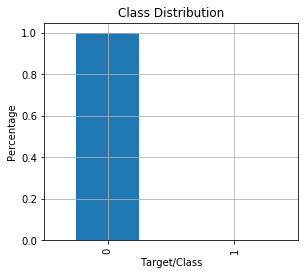

In [7]:
# examining the class distribution
cr = credit["Class"].value_counts()/credit["Class"].count()
fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(121)
ax1.set_xlabel('Target/Class')
ax1.set_ylabel('Percentage')
ax1.set_title("Class Distribution")
cr.plot(kind='bar', grid = True)

In [8]:
# print percentages of the two classes
fraud_count = len(credit[credit["Class"]==1])
not_fraud_count = len(credit[credit["Class"]==0])

percent_not_fraud = not_fraud_count/(not_fraud_count + fraud_count)
fraud_percent = fraud_count/(not_fraud_count + fraud_count)
print("Not fraud transactions percent: ", percent_not_fraud*100)
print("Fraudulent transactions percent: ", fraud_percent*100)

Not fraud transactions percent:  99.82725143693798
Fraudulent transactions percent:  0.1727485630620034


The two visuals below are for fraudulent and non-fraudulent transactions. We can infer that fraudulent transactions appear to be all less than 2,500 dollars per transaction, with a significant number of transactions concentrated in the 0 and 500 dollars. Alternatively, there is more of a spread in non_fraudulent transactions. This is an interesting observation in that contrary to expectations, fraudulent transactions tend to be in smaller amounts per this dataset. Why that is the case is probably an issue worth further investigatin.

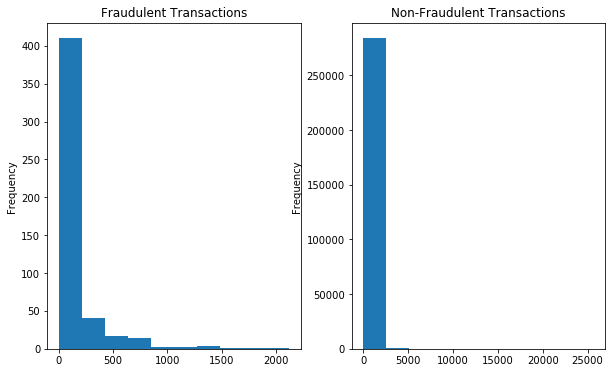

In [9]:
fraud = credit[credit["Class"]==1]
normal = credit[credit["Class"]==0]

plt.figure(figsize=(10,6))
plt.subplot(121)
fraud.Amount.plot.hist(title="Fraudulent Transactions")
plt.subplot(122)
normal.Amount.plot.hist(title="Non-Fraudulent Transactions")

In [10]:
# review column names
credit.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [11]:
# .info provides data type for each variable, as well as indicates if there are null values
# in the data
credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

In [12]:
# another confirmation there are missing values
credit.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

Though not meaningful, the summary stats indicate that the minimum transaction amount is 0.00 dollars while maximum amount is about 26,000 dollars. The mean amount is 88.00 dollars, and we also do see that 75 percent of all transactions were less than 77.00 dollars.

In [13]:
# though not meaningful, we get the summary statistics of the data
credit.describe(include="all")

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.758743e-12,-8.252298e-13,-9.636929e-13,8.316157e-13,1.591952e-13,4.247354e-13,-3.050180e-13,8.693344e-14,-1.179712e-12,...,-3.406543e-13,-5.713163e-13,-9.725303e-13,1.464139e-12,-6.989087e-13,-5.615260e-13,3.332112e-12,-3.518886e-12,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [14]:
# assigning the predictor variables to object X
X = credit[['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
                'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
                'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']]
X.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99


In [15]:
# assigning target variable to object y
y = credit.Class

All variables except time and amount are essentially principal components, as noted already. Therefore, examining variable distributions does not make sense as we cannot really interpret princinpal component variables. However, we will need to scale the data to bring all features to a common scale. Therefore, we standardize amount variable into a new variable using the sklearn's standard scaler. In addition, we drop "time" variable as it is essentially a sequantial variable per transaction, and we also drop the original amount variable.

In [16]:
# we want all variable to be on a common scale. 
# Standardization, rather than normalization, has been proven to be more effective
# as it essentially normalizes the variables to mean 0 and standard deviation 1 
# thus achieving a normal distribution.
from sklearn.preprocessing import StandardScaler
X["Amount_scl"] = StandardScaler().fit_transform(X["Amount"].values.reshape(-1, 1))
X = X.drop(["Time", "Amount"], axis=1)
X.head(10)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount_scl
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.244964
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.342475
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.160686
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.140534
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,-0.073403
5,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,-0.371407,...,0.084968,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,-0.338556
6,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,-0.099254,...,-0.219633,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,-0.333279
7,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,1.249376,...,-0.156742,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,-0.190107
8,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,-0.410430,...,0.052736,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,0.019392
9,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,-0.366846,...,0.203711,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,-0.338516


In [17]:
# with data standardized, we split into train and test set, both X and Y sets
# we retain 30% to test the model, using train_test_split function
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)


In [18]:
# printing the split data
print("Predictor tain set: ", X_train.shape)
print("Predictor test set: ", X_test.shape)
print("Target train set: ", y_train.shape)
print("Target test set: ", y_test.shape)

Predictor tain set:  (199364, 29)
Predictor test set:  (85443, 29)
Target train set:  (199364,)
Target test set:  (85443,)


# Section 3: Modeling

#### The data is clearly class-imbalanced. While there are a number of techniques to dealing with class imbalance issues, we will first build a few models without rebalancing, and assess model quality, afterwhich we will make certain decisions on how to balance the dataset

In [19]:
# defining a function to measure model performance
from sklearn import metrics

def measure_performance(X, y, clf, show_accuracy=True, show_classification_report=True, show_confussion_matrix=True):
    y_pred = clf.predict(X)   
    if show_accuracy:
         print("Accuracy:{0:.3f}".format(metrics.accuracy_score(y, y_pred)),"\n")
    if show_classification_report:
        print("Classification report")
        print(metrics.classification_report(y, y_pred),"\n")
      
    if show_confussion_matrix:
        print("Confussion matrix")
        print(metrics.confusion_matrix(y, y_pred),"\n")

### Logistic Regression - imbalanced data

In [20]:
# import logistic function from sklearn
# and initialize the logistic reg object
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=1.0, random_state=0)
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [21]:
# make predictions based on test set
lrpred_test = lr.predict(X_test)

In [22]:
# import classification report
from sklearn.metrics import classification_report

As the data is highly class imbalanced, the more appropriate measure of correct classification is recall/precsion. From the classification report below, we see that while the logit has average recall/precission of 100% - a perfect classifier -- the classifier is doing a terrible job correctly classifying fraudulent transactions. In effect, recall for the fraud is 62%, meaning the model only labeled 62% of fraudulent transactions as such. Precision is somewhat higher at 88% for the positive class, meaning that 89% of the positive class that were labeled as positive are indeed positive.

In [23]:
print(classification_report(y_test, lrpred_test))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     85296
          1       0.88      0.62      0.73       147

avg / total       1.00      1.00      1.00     85443



In [24]:
from sklearn.metrics import confusion_matrix
# initialize the confusion matrix
lr_cm = (confusion_matrix(y_test, lrpred_test))

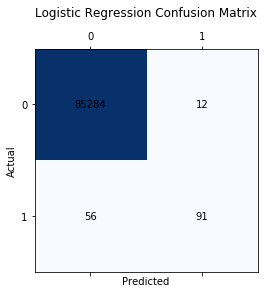

In [25]:
# visualize the confusion matrix
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
plt.matshow(lr_cm, cmap = plt.cm.Blues)
plt.title("Logistic Regression Confusion Matrix\n")
plt.ylabel("Actual")
plt.xlabel("Predicted")
for y in range(lr_cm.shape[0]):
    for x in range(lr_cm.shape[1]):
        plt.text(x, y, '{}'.format(lr_cm[y, x]),
                horizontalalignment = 'center',
                verticalalignment = 'center',)
plt.show()

### Random Forest - imbalanced data

In [26]:
# fitting a base random forest on class imbalance data
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf = rf.fit(X_train, y_train)

Validated on the class imbalanced test data, the random forest materially improves over the logistic regression. As one would expect, overall accuracy is 100%. Recall on the negative class is 100% as well. However, recall on the positive class is 73%, an 11 percentage improvement over the logistic regression. Interpreted, this means the random forest is accurately predicting 73% of the positve class AS POSITIVE. The F1-score is also strong compared to the logistic regression. 

#### Question of interest - can the recall be further improved? In the next section, techniques for dealing with class imbalance are identified and employed. We then train a hyperparameter tuned random forest and measure performance on the original unbalanced test set.

In [27]:
# measure performance, on the original unbalanced test set
measure_performance(X_test, y_test, rf, show_confussion_matrix=True, show_classification_report=True)

Accuracy:0.999 

Classification report
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     85296
          1       0.94      0.72      0.82       147

avg / total       1.00      1.00      1.00     85443
 

Confussion matrix
[[85289     7]
 [   41   106]] 



## Data Balancing

#### From the simple logistic regression and random forest, it is clear any algorithm trained on the class-imbalanced data will probably have lower recall values. It is imperative we employ techniques for dealing with class imbalance.  General techniques include:

1. Resampling techniques - over/under sampling
2. Different performance metrics besides Accuracy: recall/precision, sensitivity, F-measure, AUCPR and Kappa.
3. SMOTE - synthetically generate additional features of rare class
4. Threshold moving
5. Ensemble techniques
6. Collect additional data - often expensive, not practical!

#### For the modeling tasks included here, we implemented techniques 1 (undersampling), 2, and 5 (ensemble technique).

In [28]:
# libraries needed for undersampling
from imblearn.over_sampling import SMOTE
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler

In [29]:
# initialize the undersampler
rus = RandomUnderSampler(random_state=0)
# we undersample the original TRAINING data, while leaving the original test set as unseen data
X_res, y_res = rus.fit_sample(X_train, y_train)
# while faily small, we get a balanced sample that includes 70 percent of fraudulent transactions
print('Resampled dataset shape {}'.format(Counter(y_res)))

Resampled dataset shape Counter({1: 345, 0: 345})


## Random Forest - balanced data
With the data balanced, using gridsearch, we fit a hyperparameter tuned random forest on the undersampled data. We then validate model peformance on the original class-imbalance test set. 

In [30]:
# initialize random forest estimator
rf_test = RandomForestClassifier(n_estimators=100)

In [31]:
# import libraries needed
from time import time
from scipy.stats import randint as sp_randint
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [32]:
# use a full grid over all parameters
param_grid = {"max_depth": [3, None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 4, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run grid search
grid_search = GridSearchCV(rf_test, param_grid=param_grid)
start = time()
grid_search.fit(X_res, y_res)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.cv_results_['params'])))

GridSearchCV took 117.68 seconds for 216 candidate parameter settings.


In [33]:
# getting the best grid search parameters
grid_search.best_params_

{'bootstrap': False,
 'criterion': 'entropy',
 'max_depth': None,
 'max_features': 10,
 'min_samples_leaf': 3,
 'min_samples_split': 2}

With the best parameter estimates, we refitted a final model, on the class-balanced data. Wen then measured performance on original class-imbalanced unseen test set. Generally, with a random forest, there is no need for cross validation, as cross validation is performed during the bootstrap aggregation during model training. As can be noted, by hyperparameter tuning, we attained significant improvement to class of interest recall by 20 percentage points to 92%. Essentially, the final model is accurately predicting 92% of the fraudulent transactions as fraud, which is robust in such as highly class imbalanced data.

In [36]:
# fit the final model
from sklearn.ensemble import RandomForestClassifier
rf_final = RandomForestClassifier(n_estimators=100, 
                            min_samples_split=2, 
                            max_depth=None, 
                            max_features=10,
                           min_samples_leaf=3,
                           criterion="entropy",
                           bootstrap=False)
rf_final = rf_final.fit(X_res, y_res)

In [37]:
measure_performance(X_test, y_test, rf_final, show_confussion_matrix=True, show_classification_report=True)

Accuracy:0.972 

Classification report
             precision    recall  f1-score   support

          0       1.00      0.97      0.99     85296
          1       0.05      0.92      0.10       147

avg / total       1.00      0.97      0.98     85443
 

Confussion matrix
[[82875  2421]
 [   12   135]] 



# Section 4: Conclusion

In the above analysis, we went through an iterative KDD process, from data understanding, data preprocessing, exploratory data analysis, data reduction/scaling and modeling as well as selecting the final model. As previously noted, considering the severe class imbalance in the data, we employed resampling techniques, different measures of model accuracy as well as ensemble learning. We then trained two models on the class imbalanced data, with modest predictions, afterwhich we balanced the data and trained a final random forest model that achieved significantly better results on the unseen CLASS-IMBALANCED test set. 

However, it should be noted that while our FINAL model has recall = 92% on the class of interest (overall recall = 98%), precision has materially suffered. However, in fraud detection, my view is that we want to maximize recall on the class of interest at the expense of precision - we care more about predicting that what we predict as fraud, is actually fraud. So while our precision in the final model positive class is negligible, we are okay with that. 